In [ ]:
# Kaggle API 키 설정
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

# Kaggle 데이터 다운로드
!kaggle datasets download -d jonathansilva2020/orange-diseases-dataset
!unzip /content/orange-diseases-dataset.zip -d /content/orange-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/jonathansilva2020/orange-diseases-dataset
License(s): CC-BY-NC-SA-4.0
 97% 134M/138M [00:01<00:00, 168MB/s]
100% 138M/138M [00:01<00:00, 143MB/s]
Archive:  /content/orange-diseases-dataset.zip
  inflating: /content/orange-diseases-dataset/test/blackspot/b (1).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (10).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (11).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (12).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (13).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (14).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (15).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (16).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (17).jpg  
  inflating: /content/orange-diseases-dataset/test/blackspot/b (18).jpg  
  inflating: /content/o

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
data_dir = "/content/orange-diseases-dataset"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# 클래스 확인
classes = os.listdir(train_dir)
print("클래스 목록:", classes)

클래스 목록: ['canker', 'blackspot', 'fresh', 'grenning']


In [ ]:
# 이미지 크기 및 배치 설정
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# 강력한 데이터 증강 적용
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=45,  # 회전 범위 증가
    width_shift_range=0.2,  # 가로 이동
    height_shift_range=0.2,  # 세로 이동
    horizontal_flip=True,  # 좌우 반전
    brightness_range=[0.5, 1.5],  # 밝기 조절
    zoom_range=0.3,  # 줌 조정
    shear_range=0.2,  # 기울이기 적용
    channel_shift_range=50.0  # 채널 색상 변형
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# 데이터 로딩
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

val_data = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)


Found 991 images belonging to 4 classes.
Found 99 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# EfficientNetV2 모델 불러오기 (Pretrained weights 사용)
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# 기존 가중치 동결 (전이 학습)
base_model.trainable = False

# 분류기 추가
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)  # 더 큰 히든 레이어 추가
x = Dropout(0.4)(x)  # Dropout 증가
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(len(classes), activation="softmax")(x)  # 클래스 개수만큼 출력 노드 설정

# 모델 생성
model = Model(inputs=base_model.input, outputs=x)

# 모델 컴파일
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 모델 요약 출력
model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 128, 128, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 128, 128, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 128, 128, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 128, 128, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 128, 128, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 128, 128, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 128, 128, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 128, 128, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 128, 128, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 21,119,588 (80.56 MB)

 Trainable params: 788,228 (3.01 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
# 모델 학습 설정
EPOCHS = 10

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.4311 - loss: 1.2523 - val_accuracy: 0.6667 - val_loss: 0.8779
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 620ms/step - accuracy: 0.5388 - loss: 1.0870 - val_accuracy: 0.6162 - val_loss: 0.8991
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 623ms/step - accuracy: 0.5700 - loss: 1.0754 - val_accuracy: 0.6970 - val_loss: 0.8589
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.5645 - loss: 1.0276 - val_accuracy: 0.7677 - val_loss: 0.7917
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 615ms/step - accuracy: 0.5688 - loss: 1.0342 - val_accuracy: 0.5657 - val_loss: 0.8771
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 617ms/step - accuracy: 0.5719 - loss: 1.0161 - val_accuracy: 0.6869 - val_loss: 0.7035
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 620ms/step - accuracy: 0.6048 - loss: 0.9562 - val_accuracy: 0.7778 - val_loss: 0.6911
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 623ms/step - accuracy: 0.5951 - loss: 0.9692 - val_accura

In [ ]:
# 일부 레이어를 학습 가능하도록 설정
base_model.trainable = True

# 모델 재컴파일 (학습률 낮춤)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

# 추가 학습
EPOCHS_FINE_TUNE = 5

history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_FINE_TUNE,
    verbose=1
)


Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.3557 - loss: 2.5163 - val_accuracy: 0.4747 - val_loss: 1.4684
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 618ms/step - accuracy: 0.6260 - loss: 0.9638 - val_accuracy: 0.4444 - val_loss: 1.0839
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 626ms/step - accuracy: 0.7285 - loss: 0.6226 - val_accuracy: 0.7172 - val_loss: 0.4937
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.7821 - loss: 0.4725 - val_accuracy: 0.7778 - val_loss: 0.3848
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 622ms/step - accuracy: 0.7985 - loss: 0.4422 - val_accuracy: 0.7980 - val_loss: 0.3622


In [ ]:
# 검증 데이터 평가
val_loss, val_acc = model.evaluate(val_data)
print(f"✅ Validation Accuracy: {val_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7827 - loss: 0.3624 
✅ Validation Accuracy: 0.7980


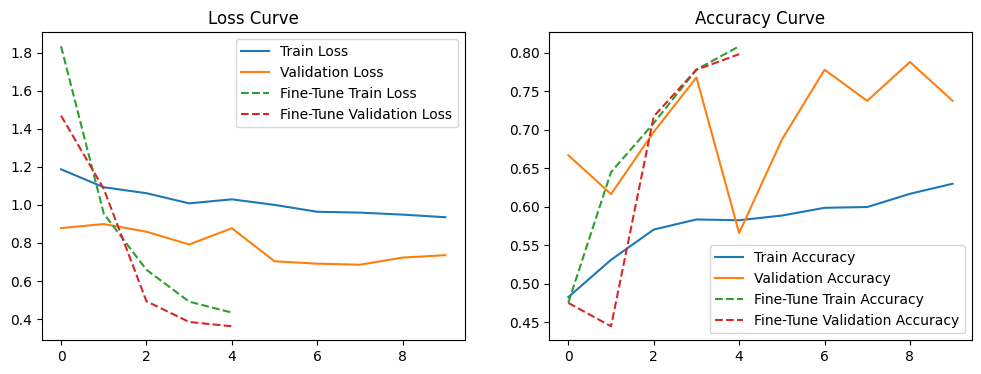

In [ ]:
import matplotlib.pyplot as plt

# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history_finetune.history["loss"], label="Fine-Tune Train Loss", linestyle="dashed")
plt.plot(history_finetune.history["val_loss"], label="Fine-Tune Validation Loss", linestyle="dashed")
plt.legend()
plt.title("Loss Curve")

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history_finetune.history["accuracy"], label="Fine-Tune Train Accuracy", linestyle="dashed")
plt.plot(history_finetune.history["val_accuracy"], label="Fine-Tune Validation Accuracy", linestyle="dashed")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


🔧 추가 개선 방법
Early Stopping 적용 (최적 지점에서 학습 멈추기)

과적합을 막기 위해 검증 손실이 줄지 않으면 학습을 멈추도록 설정
python
복사
편집
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
학습률(Learning Rate) 조정

Fine-tuning 시 1e-5 대신 1e-4 정도로 설정하면 더 좋은 결과 가능
Dropout 추가하여 일반화 성능 개선

검증 정확도 변동이 크므로 Dropout(0.3~0.5)을 적용하면 더 안정적일 가능성 있음
데이터 증강(Augmentation) 적용

데이터 부족으로 인해 모델이 특정 패턴에 과적합했을 가능성 있음
ImageDataGenerator 또는 Albumentations로 데이터 다양화
